### import libraries

In [122]:
!pip install imbalanced-learn
!pip install xgboost

In [123]:
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTENC, SMOTEN
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier

#### import dataset

In [124]:
df_appl = pd.read_csv('F:\\HND\ML\\Assignment\\archive\\application_record.csv')
df_credit = pd.read_csv('F:\\HND\ML\\Assignment\\archive\\credit_record.csv')

In [125]:
print('number of unique customer IDs, First table',df_appl['ID'].nunique())
print('number of unique customer IDs, Second table',df_credit['ID'].nunique())
print('Number of unique IDs in both tables:',df_appl[df_appl['ID'].isin(df_credit['ID'])]['ID'].nunique())

number of unique customer IDs, First table 438510
number of unique customer IDs, Second table 45985
Number of unique IDs in both tables: 36457


In [126]:
df_appl = df_appl[df_appl['ID'].isin(df_credit['ID'])]
df_credit = df_credit[df_credit['ID'].isin(df_appl['ID'])]


##### We first establish the criteria because the data only gives us the credit record (status), not the ability to decide whether to issue a credit card.

In [127]:
#Make label

def label_bad(df_appl):
    if (df_appl["STATUS"]=='3') | (df_appl["STATUS"]=='4') | (df_appl["STATUS"]=='5'): # bad
        return 2
    elif (df_appl["STATUS"]=='X'): # no record
        return -1
    elif (df_appl["STATUS"]=='0') | (df_appl["STATUS"]=='1') | (df_appl["STATUS"]=='2'): # indeterminates
        return 1
    else:
        return 0
    
df_appl.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1


In [128]:
df_credit["MONTHS_BALANCE"] = -df_credit["MONTHS_BALANCE"]
df_credit = df_credit[df_credit["MONTHS_BALANCE"]<=12]
df_credit["B_Customer"] = df_credit.apply(label_bad, axis=1)

In [129]:
df_credit_labeled = df_credit[['ID','B_Customer',"MONTHS_BALANCE"]].groupby('ID',as_index=False).max()

In [130]:
df_credit_labeled

,ID,B_Customer,MONTHS_BALANCE
0,5008804,0,12
1,5008805,1,12
2,5008806,1,12
3,5008808,1,4
4,5008810,0,12
...,...,...,...
29746,5150482,0,12
29747,5150483,-1,12
29748,5150484,1,12
29749,5150485,1,1


In [131]:
#  customer with only X status (no usage data) (label = -1)
df_credit_labeled = df_credit_labeled[df_credit_labeled['B_Customer']!=-1]
#  indeterminates customer (label = 1)
df_credit_labeled = df_credit_labeled[df_credit_labeled['B_Customer']!=1]
#  customer with period of record less than 12 month
df_credit_labeled = df_credit_labeled[df_credit_labeled['MONTHS_BALANCE']==12]
# Tag Bad_customer as 1 instead 2
df_credit_labeled['B_Customer'] = (df_credit_labeled['B_Customer']/2).apply(np.int32)
df_credit_labeled =  df_credit_labeled.drop('MONTHS_BALANCE', axis=1)

In [132]:
df_credit_labeled.head()

,ID,B_Customer
0,5008804,0
4,5008810,0
5,5008811,0
16,5008826,0
17,5008827,0


In [133]:
# merge
df_labeled = df_appl.merge(df_credit_labeled,on='ID',how='inner')

### Observe and clean data

In [134]:
df_labeled.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,B_Customer
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2,0
1,5008810,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,0
2,5008811,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,0
3,5008826,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2,0
4,5008830,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2,0
5,5008832,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2,0
6,5008834,F,N,Y,1,112500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-10968,-1620,1,0,0,0,NaN,2,0
7,5008836,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,-12689,-1163,1,0,0,0,Laborers,5,0
8,5008837,M,Y,Y,3,270000.0,Working,Secondary / secondary special,Married,House / apartment,-12689,-1163,1,0,0,0,Laborers,5,0
9,5008840,M,N,Y,1,405000.0,Commercial associate,Higher education,Married,House / apartment,-11842,-2016,1,0,0,0,Managers,3,0


In [135]:
df_labeled = df_labeled.drop('ID',axis=1)

In [136]:
# Check whether multiple cards holder are labeled with bad/good or mixing
print('Amount of duplicated data with bad customer labeling: ', df_labeled.duplicated().sum())
print('Amount of duplicated data without bad customer labeling: ', df_labeled.drop('B_Customer',axis=1).duplicated().sum())

Amount of duplicated data with bad customer labeling:  5271
Amount of duplicated data without bad customer labeling:  5313


In [137]:
# Flag duplicate information that come from the same customer
df_labeled['ID_same_customer'] = df_labeled.groupby(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'], dropna=False).ngroup()

In [138]:
df_labeled

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,B_Customer,ID_same_customer
0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2,0,4672
1,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,0,1902
2,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1,0,1902
3,F,Y,N,0,130500.0,Working,Incomplete higher,Married,House / apartment,-10669,-1103,1,0,0,0,Accountants,2,0,2464
4,F,N,Y,0,157500.0,Working,Secondary / secondary special,Married,House / apartment,-10031,-1469,1,0,1,0,Laborers,2,0,1538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10255,F,N,Y,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15837,-2694,1,1,1,0,NaN,2,0,1070
10256,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,2,0,4559
10257,M,Y,Y,0,247500.0,Working,Secondary / secondary special,Married,House / apartment,-10952,-3577,1,1,0,0,Laborers,2,0,4559
10258,F,N,Y,0,157500.0,Commercial associate,Higher education,Married,House / apartment,-12387,-1325,1,0,1,1,Medicine staff,2,1,1439


In [139]:
# Combine information to be just 1 for each customer. Bad_customer tag is 1 if one or more ID is tagged as bad_customer
df_labeled = df_labeled.groupby(['ID_same_customer','CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS'],as_index=False,dropna=False).max()

In [140]:
# Recheck duplicates
df_labeled.drop('ID_same_customer',axis=1).duplicated().sum()

0

#### Check for missing data¶


In [141]:
df_labeled.isna().sum()/df_appl.shape[0]*100

ID_same_customer       0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        4.226897
CNT_FAM_MEMBERS        0.000000
B_Customer             0.000000
dtype: float64

Text(0.5, 1.0, 'Income type of customers (without occupation data)')

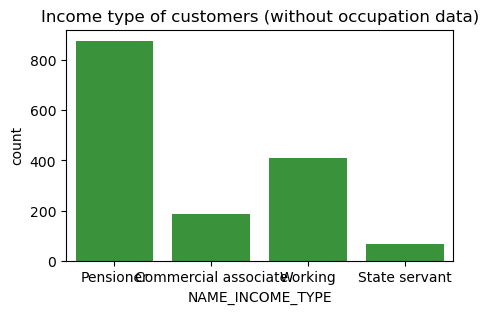

In [142]:
plt.figure(figsize=(5,3))
sns.countplot(x= df_labeled[df_labeled["OCCUPATION_TYPE"].isna()]["NAME_INCOME_TYPE"], color='tab:green')
plt.title("Income type of customers (without occupation data)")

In [143]:
 # label pensioner occupation type
df_labeled.loc[df_labeled["NAME_INCOME_TYPE"]=="Pensioner","OCCUPATION_TYPE"] = "Pensioner"

In [144]:
# Check missing data after assigning pensioner
df_labeled.isna().sum()/df_appl.shape[0]*100

ID_same_customer       0.000000
CODE_GENDER            0.000000
FLAG_OWN_CAR           0.000000
FLAG_OWN_REALTY        0.000000
CNT_CHILDREN           0.000000
AMT_INCOME_TOTAL       0.000000
NAME_INCOME_TYPE       0.000000
NAME_EDUCATION_TYPE    0.000000
NAME_FAMILY_STATUS     0.000000
NAME_HOUSING_TYPE      0.000000
DAYS_BIRTH             0.000000
DAYS_EMPLOYED          0.000000
FLAG_MOBIL             0.000000
FLAG_WORK_PHONE        0.000000
FLAG_PHONE             0.000000
FLAG_EMAIL             0.000000
OCCUPATION_TYPE        1.818581
CNT_FAM_MEMBERS        0.000000
B_Customer             0.000000
dtype: float64

In [145]:
# drop null occupation rows
df_labeled = df_labeled.dropna(axis=0)

##### Verify if any of the categorical columns have typos.


In [146]:
df_labeled["CODE_GENDER"].unique()

array(['F', 'M'], dtype=object)

In [147]:
df_labeled["FLAG_OWN_CAR"].unique()

array(['N', 'Y'], dtype=object)

In [148]:
df_labeled["FLAG_OWN_REALTY"].unique()

array(['N', 'Y'], dtype=object)

In [149]:
df_labeled["NAME_INCOME_TYPE"].unique()

array(['Working', 'Pensioner', 'State servant', 'Commercial associate',
       'Student'], dtype=object)

In [150]:
df_labeled["NAME_FAMILY_STATUS"].unique()

array(['Civil marriage', 'Married', 'Single / not married', 'Widow',
       'Separated'], dtype=object)

In [151]:
df_labeled["NAME_HOUSING_TYPE"].unique()

array(['House / apartment', 'Office apartment', 'With parents',
       'Municipal apartment', 'Co-op apartment', 'Rented apartment'],
      dtype=object)

In [152]:
df_labeled["OCCUPATION_TYPE"].unique()

array(['Managers', 'Pensioner', 'Core staff', 'Accountants',
       'Sales staff', 'Cleaning staff', 'Medicine staff', 'Laborers',
       'Security staff', 'High skill tech staff', 'Cooking staff',
       'Private service staff', 'Waiters/barmen staff', 'Secretaries',
       'HR staff', 'Low-skill Laborers', 'Drivers', 'IT staff',
       'Realty agents'], dtype=object)

#### drop sensitive data

In [153]:
# drop gender
df_labeled = df_labeled.drop("CODE_GENDER", axis=1)

In [154]:
df_labeled.head()

,ID_same_customer,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,B_Customer
0,0,N,N,0,27000.0,Working,Higher education,Civil marriage,House / apartment,-14869,-5067,1,1,0,0,Managers,2,0
1,1,N,N,0,33300.0,Pensioner,Secondary / secondary special,Married,Office apartment,-19605,365243,1,0,0,0,Pensioner,2,0
2,2,N,N,0,36000.0,Working,Secondary / secondary special,Married,With parents,-14500,-459,1,1,0,0,Core staff,2,0
3,3,N,N,0,36900.0,Pensioner,Higher education,Married,House / apartment,-22581,365243,1,0,0,0,Pensioner,2,0
4,4,N,N,0,40500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-21091,365243,1,0,0,0,Pensioner,1,0


### Analyzing exploratory data (EDA) and designing features

In [155]:
# define WOE fuction 
def WOE_cal(df,col_name):
    WOE = pd.DataFrame()
    total_bad = df["B_Customer"].sum()
    total_good = df.shape[0]-total_bad
    WOE["Dist_bad"]  = (df_labeled.groupby(col_name)["B_Customer"].sum())/total_bad
    WOE["Dist_good"] = (df_labeled.groupby(col_name)["B_Customer"].count()-df_labeled.groupby(col_name)["B_Customer"].sum())/total_good
    WOE["WOE"] = (np.log((WOE["Dist_good"]/WOE["Dist_bad"])))
    IV = (WOE["WOE"]*(WOE["Dist_good"]-WOE["Dist_bad"])).sum() # information value
    return [WOE, IV]

In [156]:
# Adjust DAYS_BIRTH to AGE in year
df_labeled["AGE"] = ((-df_labeled["DAYS_BIRTH"])/365).apply(int)
df_labeled = df_labeled.drop(["DAYS_BIRTH"],axis=1)

In [157]:
# Adjust DAYS_EMPLOYED to YEAR_EMPLOYED in year
df_labeled["YEAR_EMPLOYED"] = np.ceil(-(df_labeled["DAYS_EMPLOYED"]/365))
df_labeled = df_labeled.drop(["DAYS_EMPLOYED"],axis=1)

In [158]:
df_labeled = df_labeled.reset_index(drop=True)
df_labeled = df_labeled.drop(["ID_same_customer"],axis=1)

In [159]:
df_labeled.head()

,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,B_Customer,AGE,YEAR_EMPLOYED
0,N,N,0,27000.0,Working,Higher education,Civil marriage,House / apartment,1,1,0,0,Managers,2,0,40,14.0
1,N,N,0,33300.0,Pensioner,Secondary / secondary special,Married,Office apartment,1,0,0,0,Pensioner,2,0,53,-1000.0
2,N,N,0,36000.0,Working,Secondary / secondary special,Married,With parents,1,1,0,0,Core staff,2,0,39,2.0
3,N,N,0,36900.0,Pensioner,Higher education,Married,House / apartment,1,0,0,0,Pensioner,2,0,61,-1000.0
4,N,N,0,40500.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,1,0,0,0,Pensioner,1,0,57,-1000.0


##### FLAG_MOBIL, FLAG_WORK_PHONE, FLAG_PHONE, and FLAG_EMAIL

###### FLAG_MOBIL (Is there a mobile phone) is 1 for all row, which is not a beneficial data.

In [160]:
# Show that FLAG_MOBIL only contain value 1
df_labeled["FLAG_MOBIL"].value_counts()

1    4284
Name: FLAG_MOBIL, dtype: int64

In [161]:
# Drop FLAG_MOBIL
df_labeled = df_labeled.drop('FLAG_MOBIL',axis=1)

### Check WOE, and IV of the rest

In [162]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_WORK_PHONE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.005711083265458758


,Dist_bad,Dist_good,WOE
FLAG_WORK_PHONE,,,
1,0.247312,0.215462,-0.137867
0,0.752688,0.784538,0.041444


In [163]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_PHONE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.020088810078150013


,Dist_bad,Dist_good,WOE
FLAG_PHONE,,,
1,0.354839,0.288714,-0.206227
0,0.645161,0.711286,0.097574


In [164]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_EMAIL")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.015541933951965283


,Dist_bad,Dist_good,WOE
FLAG_EMAIL,,,
1,0.11828,0.081126,-0.377045
0,0.88172,0.918874,0.041274


##### As FLAG_WORK_PHONE and FLAG_EMAIL have IVs that are far lower 

In [165]:
# Drop old flag
df_labeled = df_labeled.drop(["FLAG_WORK_PHONE","FLAG_EMAIL","FLAG_PHONE"],axis=1)

#### FLAG_OWN_CAR

In [166]:
# Percentage of sample of each income type
df_labeled["FLAG_OWN_CAR"].value_counts(normalize=True)*100

N    62.138189
Y    37.861811
Name: FLAG_OWN_CAR, dtype: float64

In [167]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_OWN_CAR")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.0025440155398926954


,Dist_bad,Dist_good,WOE
FLAG_OWN_CAR,,,
N,0.645161,0.620854,-0.038404
Y,0.354839,0.379146,0.066257


In [168]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_OWN_CAR")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.0025440155398926954


,Dist_bad,Dist_good,WOE
FLAG_OWN_CAR,,,
N,0.645161,0.620854,-0.038404
Y,0.354839,0.379146,0.066257


In [169]:
# Drop FLAG_OWN_CAR as IV is very low
df_labeled = df_labeled.drop(["FLAG_OWN_CAR"],axis=1)

In [170]:
# Percentage of sample of each income type
df_labeled["FLAG_OWN_REALTY"].value_counts(normalize=True)*100

Y    66.643324
N    33.356676
Name: FLAG_OWN_REALTY, dtype: float64

In [171]:
[WOE, IV] = WOE_cal(df_labeled,"FLAG_OWN_REALTY")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.013018083799736657


,Dist_bad,Dist_good,WOE
FLAG_OWN_REALTY,,,
N,0.387097,0.332379,-0.152399
Y,0.612903,0.667621,0.085514


In [172]:
# Drop FLAG_OWN_CAR as IV is very low
df_labeled = df_labeled.drop(["FLAG_OWN_REALTY"],axis=1)

#### NAME_INCOME_TYPE (Type of income)

In [173]:
# Percentage of sample of each income type
df_labeled["NAME_INCOME_TYPE"].value_counts(normalize=True)*100

Working                 48.646125
Commercial associate    22.992530
Pensioner               20.728291
State servant            7.609711
Student                  0.023343
Name: NAME_INCOME_TYPE, dtype: float64

##### We are not able to reassign them to a different group because of the low student frequency. We decided to part with it.

In [174]:
df_labeled = df_labeled[df_labeled["NAME_INCOME_TYPE"]!="Student"]
df_labeled["NAME_INCOME_TYPE"].value_counts(normalize=True)*100

Working                 48.657483
Commercial associate    22.997899
Pensioner               20.733131
State servant            7.611487
Name: NAME_INCOME_TYPE, dtype: float64

In [175]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_INCOME_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.08690258519566955


,Dist_bad,Dist_good,WOE
NAME_INCOME_TYPE,,,
Commercial associate,0.279570,0.228878,-0.200062
Pensioner,0.236559,0.206683,-0.135014
Working,0.462366,0.487112,0.052139
State servant,0.021505,0.077327,1.279740


#### NAME_EDUCATION_TYPE (Type of education)

In [176]:
# Percentage of sample of each education type
df_labeled["NAME_EDUCATION_TYPE"].value_counts(normalize=True)*100

Secondary / secondary special    70.044361
Higher education                 25.449451
Incomplete higher                 3.105300
Lower secondary                   1.354191
Academic degree                   0.046696
Name: NAME_EDUCATION_TYPE, dtype: float64

In [177]:
df_labeled["NAME_EDUCATION_TYPE"] = df_labeled["NAME_EDUCATION_TYPE"].replace({"Academic degree":"Higher education","Lower secondary":"Secondary/Lower","Secondary / secondary special":"Secondary/Lower"})
df_labeled["NAME_EDUCATION_TYPE"].value_counts(normalize=True)*100 


Secondary/Lower      71.398552
Higher education     25.496148
Incomplete higher     3.105300
Name: NAME_EDUCATION_TYPE, dtype: float64

In [178]:
df_labeled["NAME_EDUCATION_TYPE"] = df_labeled["NAME_EDUCATION_TYPE"].replace({"Academic degree":"Higher education","Lower secondary":"Secondary/Lower","Secondary / secondary special":"Secondary/Lower"})
df_labeled["NAME_EDUCATION_TYPE"].value_counts(normalize=True)*100

Secondary/Lower      71.398552
Higher education     25.496148
Incomplete higher     3.105300
Name: NAME_EDUCATION_TYPE, dtype: float64

In [179]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_EDUCATION_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.005586494848586235


,Dist_bad,Dist_good,WOE
NAME_EDUCATION_TYPE,,,
Incomplete higher,0.043011,0.030788,-0.334338
Secondary/Lower,0.720430,0.713842,-0.009186
Higher education,0.236559,0.255370,0.076515


In [180]:
df_labeled = df_labeled.drop("NAME_EDUCATION_TYPE", axis=1)

#### NAME_FAMILY_STATUS

In [181]:
df_labeled["NAME_FAMILY_STATUS"].value_counts(normalize=True)*100

Married                 68.876955
Single / not married    12.748074
Civil marriage           8.311931
Separated                5.603549
Widow                    4.459491
Name: NAME_FAMILY_STATUS, dtype: float64

In [182]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_FAMILY_STATUS")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.07927244771187314


,Dist_bad,Dist_good,WOE
NAME_FAMILY_STATUS,,,
Widow,0.064516,0.044153,-0.379260
Single / not married,0.172043,0.126492,-0.307568
Separated,0.075269,0.055609,-0.302728
Married,0.655914,0.689499,0.049935
Civil marriage,0.032258,0.084248,0.959999


In [183]:
# As WOE of Widow/not married are close together, we combined these groups.

df_labeled["NAME_FAMILY_STATUS"] = df_labeled["NAME_FAMILY_STATUS"].replace({"Widow":"Separated/Widow","Separated":"Separated/Widow"})
df_labeled["NAME_FAMILY_STATUS"].value_counts(normalize=True)*100

Married                 68.876955
Single / not married    12.748074
Separated/Widow         10.063040
Civil marriage           8.311931
Name: NAME_FAMILY_STATUS, dtype: float64

In [184]:
[WOE, IV] = WOE_cal(df_labeled,"NAME_FAMILY_STATUS")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.07909866420747196


,Dist_bad,Dist_good,WOE
NAME_FAMILY_STATUS,,,
Separated/Widow,0.139785,0.099761,-0.337324
Single / not married,0.172043,0.126492,-0.307568
Married,0.655914,0.689499,0.049935
Civil marriage,0.032258,0.084248,0.959999


#### NAME_HOUSING_TYPE

In [185]:
df_labeled["NAME_HOUSING_TYPE"].value_counts(normalize=True)*100

House / apartment      89.633435
With parents            4.342750
Municipal apartment     3.478870
Rented apartment        1.260799
Office apartment        0.863880
Co-op apartment         0.420266
Name: NAME_HOUSING_TYPE, dtype: float64

In [186]:
df_labeled["NAME_HOUSING_TYPE"] = df_labeled["NAME_HOUSING_TYPE"].replace({"Co-op apartment":"House / apartment","Office apartment":"House / apartment"})
df_labeled["NAME_HOUSING_TYPE"].value_counts(normalize=True)*100

House / apartment      90.917581
With parents            4.342750
Municipal apartment     3.478870
Rented apartment        1.260799
Name: NAME_HOUSING_TYPE, dtype: float64

In [187]:
# Calculate WOE
[WOE, IV] = WOE_cal(df_labeled,"NAME_HOUSING_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.004243038632810376


,Dist_bad,Dist_good,WOE
NAME_HOUSING_TYPE,,,
House / apartment,0.924731,0.908831,-0.017344
Municipal apartment,0.032258,0.034845,0.077138
Rented apartment,0.010753,0.012649,0.162435
With parents,0.032258,0.043675,0.303017


In [188]:
# Drop NAME_HOUSING_TYPE as IV is very low
df_labeled = df_labeled.drop("NAME_HOUSING_TYPE", axis=1)

#### OCCUPATION_TYPE

In [189]:
df_labeled["OCCUPATION_TYPE"].value_counts(normalize=True)*100

Pensioner                20.733131
Laborers                 20.429605
Sales staff              10.506654
Core staff               10.389914
Managers                  9.502685
Drivers                   7.658184
High skill tech staff     4.482839
Accountants               3.689003
Medicine staff            3.572262
Security staff            2.077983
Cooking staff             1.937894
Cleaning staff            1.751109
Private service staff     0.887229
Low-skill Laborers        0.723792
Secretaries               0.583703
Waiters/barmen staff      0.490311
HR staff                  0.256829
IT staff                  0.186785
Realty agents             0.140089
Name: OCCUPATION_TYPE, dtype: float64

In [190]:
df_labeled = df_labeled[~df_labeled["OCCUPATION_TYPE"].isin(["Private service staff","Low-skill Laborers","Secretaries","Waiters/barmen staff","HR staff","IT staff","Realty agents"])]

In [191]:
# Calculate WOE
[WOE, IV] = WOE_cal(df_labeled,"OCCUPATION_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.08176213036065198


,Dist_bad,Dist_good,WOE
OCCUPATION_TYPE,,,
Security staff,0.044944,0.020967,-0.762466
High skill tech staff,0.067416,0.045881,-0.384836
Cleaning staff,0.022472,0.018007,-0.221511
Medicine staff,0.044944,0.036754,-0.201171
Pensioner,0.247191,0.213616,-0.145981
Cooking staff,0.022472,0.019980,-0.117521
Managers,0.101124,0.098175,-0.029596
Laborers,0.202247,0.211396,0.044243
Core staff,0.101124,0.107548,0.061595


In [192]:
# GROUP BY WOE SCORE
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Security staff":"G1"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"High skill tech staff":"G2"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Cleaning staff":"G3","Medicine staff":"G3"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Pensioner":"G4","Cooking staff":"G4"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Managers":"G5","Laborers":"G5","Core staff":"G5"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Drivers":"G6"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Accountants":"G7"})
df_labeled['OCCUPATION_TYPE'] = df_labeled['OCCUPATION_TYPE'].replace({"Sales staff":"G8"})

df_labeled['OCCUPATION_TYPE'].value_counts(normalize=True)*100

G5    41.684769
G4    23.437123
G8    10.861694
G6     7.916968
G3     5.503259
G2     4.634323
G7     3.813662
G1     2.148202
Name: OCCUPATION_TYPE, dtype: float64

In [193]:
[WOE, IV] = WOE_cal(df_labeled,"OCCUPATION_TYPE")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.08124100714762295


,Dist_bad,Dist_good,WOE
OCCUPATION_TYPE,,,
G1,0.044944,0.020967,-0.762466
G2,0.067416,0.045881,-0.384836
G3,0.067416,0.054761,-0.207905
G4,0.269663,0.233596,-0.143578
G5,0.404494,0.417119,0.030733
G6,0.067416,0.079428,0.163969
G7,0.022472,0.038481,0.537886
G8,0.056180,0.109768,0.669813


#### CNT_CHILDREN (Number of children) and CNT_FAM_MEMBERS (Number of family member)

Text(0.5, 1.0, 'Number of family member')

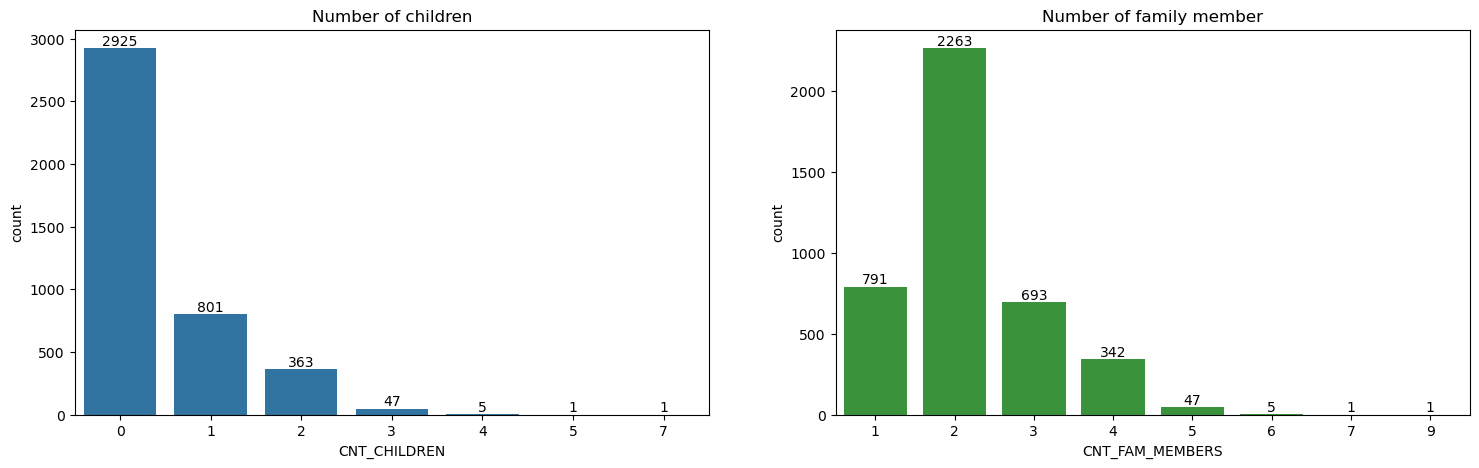

In [194]:
fig, ax = plt.subplots(1, 2, figsize = (18,5))
cplot = sns.countplot(data=df_labeled, x="CNT_CHILDREN", ax=ax[0],color='tab:blue')
for container in cplot.containers:
    cplot.bar_label(container)
ax[0].set_title('Number of children')

cplot = sns.countplot(data=df_labeled, x="CNT_FAM_MEMBERS", ax=ax[1],color='tab:green')
for container in cplot.containers:
    cplot.bar_label(container)
ax[1].set_title('Number of family member')  

Text(0.5, 1.0, 'Plot of number of family member and number of children')

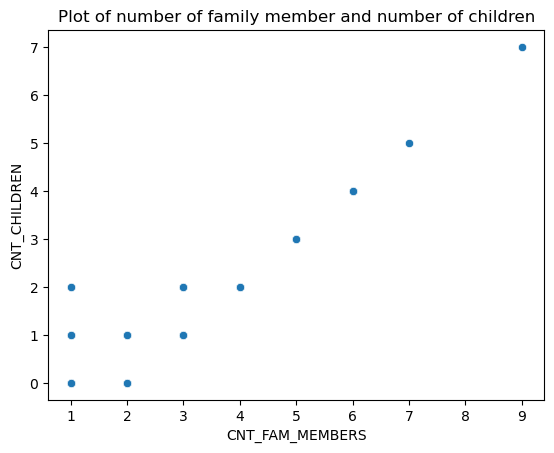

In [195]:
sns.scatterplot(data=df_labeled, x="CNT_FAM_MEMBERS",y="CNT_CHILDREN")
plt.title('Plot of number of family member and number of children')

In [196]:
df_labeled[["CNT_CHILDREN","CNT_FAM_MEMBERS"]].corr()

,CNT_CHILDREN,CNT_FAM_MEMBERS
CNT_CHILDREN,1.000000,0.882908
CNT_FAM_MEMBERS,0.882908,1.000000


In [197]:
df_labeled = df_labeled.drop("CNT_CHILDREN",axis=1)

In [198]:
df_labeled["CNT_FAM_MEMBERS"].value_counts(normalize=True)*100

2    54.622254
1    19.092445
3    16.727009
4     8.254888
5     1.134444
6     0.120685
9     0.024137
7     0.024137
Name: CNT_FAM_MEMBERS, dtype: float64

In [199]:
[WOE, IV] = WOE_cal(df_labeled,"CNT_FAM_MEMBERS")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): inf


,Dist_bad,Dist_good,WOE
CNT_FAM_MEMBERS,,,
5,0.022472,0.011100,-0.705308
1,0.269663,0.189196,-0.354390
3,0.168539,0.167242,-0.007726
2,0.494382,0.547361,0.101799
4,0.044944,0.083374,0.617929
6,0.000000,0.001233,inf
7,0.000000,0.000247,inf
9,0.000000,0.000247,inf


In [200]:
def gen_bin_fam(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize = 1
    binOver = 5
    if df < binOver:
        return str(math.ceil(df/binSize))
    else:
        return str(math.ceil(binOver/binSize))

In [201]:
df_labeled["FAM_GROUP"] = df_labeled["CNT_FAM_MEMBERS"].apply(gen_bin_fam)
df_labeled["FAM_GROUP"] = df_labeled["FAM_GROUP"].astype('object')

In [202]:
df_labeled= df_labeled.drop("CNT_FAM_MEMBERS",axis=1)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

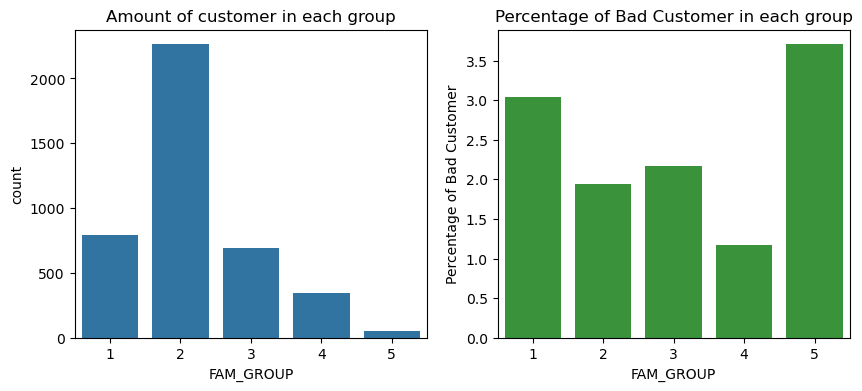

In [203]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "FAM_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=['1','2','3','4','5'],color='tab:blue')
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"B_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["B_Customer"] = df_fam_percent_bad["B_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="B_Customer", ax=ax[1],color='tab:green')
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

In [204]:
[WOE, IV] = WOE_cal(df_labeled,"FAM_GROUP")
print("Information value (IV):", IV)
WOE.sort_values("WOE")

Information value (IV): 0.06307555859223359


,Dist_bad,Dist_good,WOE
FAM_GROUP,,,
5,0.022472,0.012827,-0.560726
1,0.269663,0.189196,-0.354390
3,0.168539,0.167242,-0.007726
2,0.494382,0.547361,0.101799
4,0.044944,0.083374,0.617929


### AGE

<AxesSubplot:xlabel='AGE', ylabel='Count'>

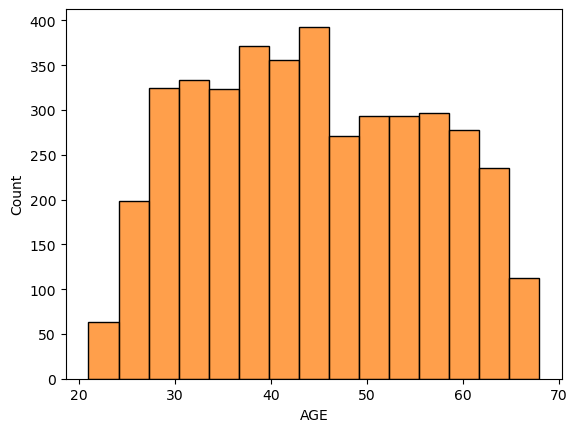

In [205]:
sns.histplot(data=df_labeled, x="AGE",bins=15,color='tab:orange')

In [206]:
def gen_bin_age(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group 
    binSize = 5
    binOver = 65
    binMin = 25
    if df <= binMin:
        return str(1)
    elif df <= binOver:
        return str(math.ceil((df-binMin)/binSize))
    else:
        return str(math.ceil((binOver-binMin)/binSize))

In [207]:
df_labeled["AGE_GROUP"] = df_labeled["AGE"].apply(gen_bin_age)
df_labeled["AGE_GROUP"] = df_labeled["AGE_GROUP"].astype('object')

In [208]:
df_labeled= df_labeled.drop("AGE",axis=1)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

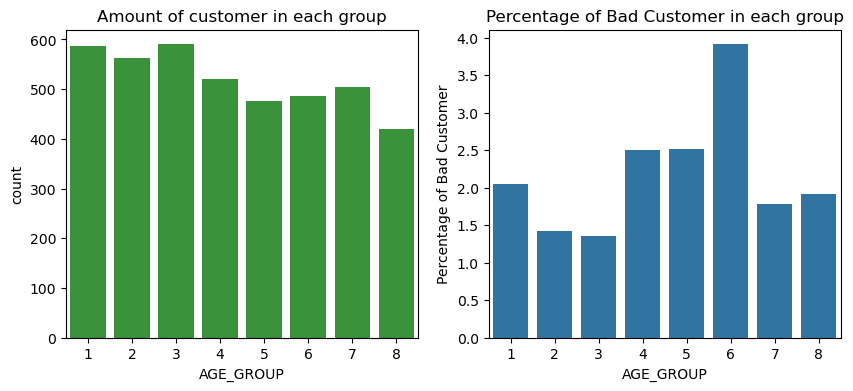

In [209]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "AGE_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=map(str,range(1,9)),color='tab:green')
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"B_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["B_Customer"] = df_fam_percent_bad["B_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="B_Customer", ax=ax[1],order=map(str,range(1,9)),color='tab:blue')
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

In [210]:
[WOE, IV] = WOE_cal(df_labeled,"AGE_GROUP")
print("Information value (IV):", IV)
WOE

Information value (IV): 0.11762678798419732


,Dist_bad,Dist_good,WOE
AGE_GROUP,,,
1,0.134831,0.141589,0.048900
2,0.089888,0.136655,0.418900
3,0.089888,0.143562,0.468206
4,0.146067,0.125062,-0.155261
5,0.134831,0.114455,-0.163845
6,0.213483,0.115195,-0.616933
7,0.101124,0.122102,0.188510
8,0.089888,0.101381,0.120329


#### AMT_INCOME_TOTAL

<AxesSubplot:xlabel='AMT_INCOME_TOTAL', ylabel='Count'>

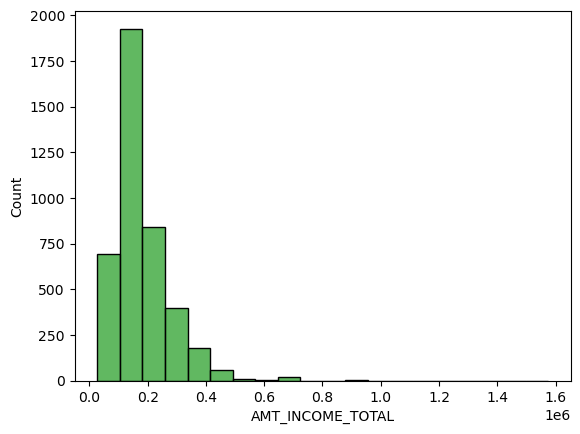

In [211]:
sns.histplot(data=df_labeled, x="AMT_INCOME_TOTAL",bins=20,color='tab:green' )

In [212]:
def gen_bin_income(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize =40000
    binOver = 320000
    binMin = 80000
    if df <= binMin:
        return str(1)
    elif df <= binOver:
        return str(math.ceil((df-binMin)/binSize))
    else:
        return str(math.ceil((binOver-binMin)/binSize))

In [213]:
df_labeled["AMT_INCOME_TOTAL_GROUP"] = df_labeled["AMT_INCOME_TOTAL"].apply(gen_bin_income)
df_labeled["AMT_INCOME_TOTAL_GROUP"] = df_labeled["AMT_INCOME_TOTAL_GROUP"].astype('object')
df_labeled= df_labeled.drop("AMT_INCOME_TOTAL",axis=1)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

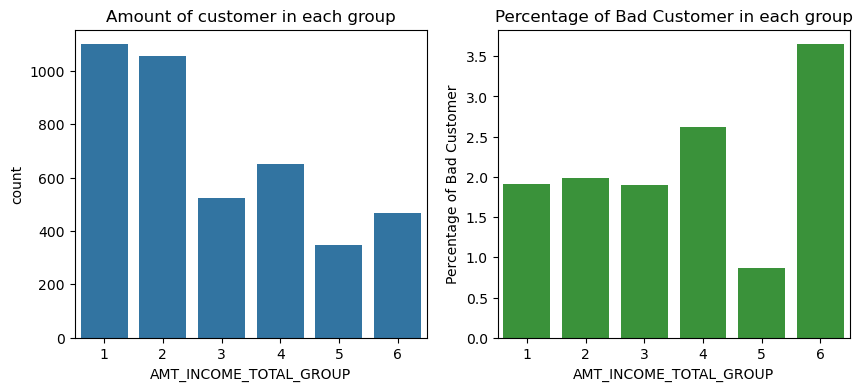

In [214]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "AMT_INCOME_TOTAL_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=['1','2','3','4','5','6'], color='tab:blue')
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"B_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["B_Customer"] = df_fam_percent_bad["B_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="B_Customer", ax=ax[1], color='tab:green')
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

In [215]:
[WOE, IV] = WOE_cal(df_labeled,"AMT_INCOME_TOTAL_GROUP")
print("Information value (IV):", IV)
WOE

Information value (IV): 0.10537685224854373


,Dist_bad,Dist_good,WOE
AMT_INCOME_TOTAL_GROUP,,,
1,0.235955,0.265910,0.119517
2,0.235955,0.255303,0.078811
3,0.112360,0.127035,0.122759
4,0.191011,0.155895,-0.203147
5,0.033708,0.085101,0.926109
6,0.191011,0.110755,-0.545013


#### YEAR_EMPLOYED

<AxesSubplot:xlabel='count', ylabel='YEAR_EMPLOYED'>

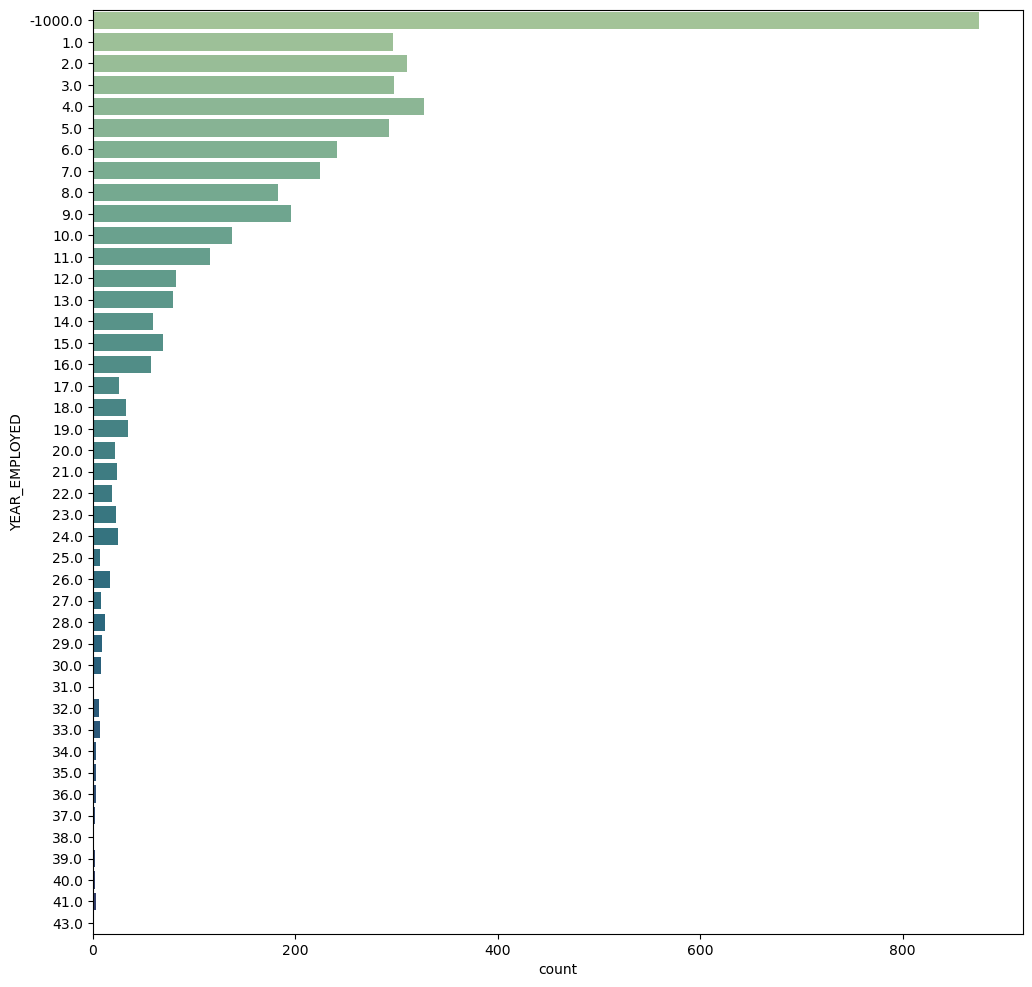

In [216]:
# Show distribution of the data
fig, ax = plt.subplots(figsize=(12, 12))
sns.countplot(data=df_labeled,y="YEAR_EMPLOYED",palette="crest")

<AxesSubplot:xlabel='B_Customer', ylabel='YEAR_EMPLOYED'>

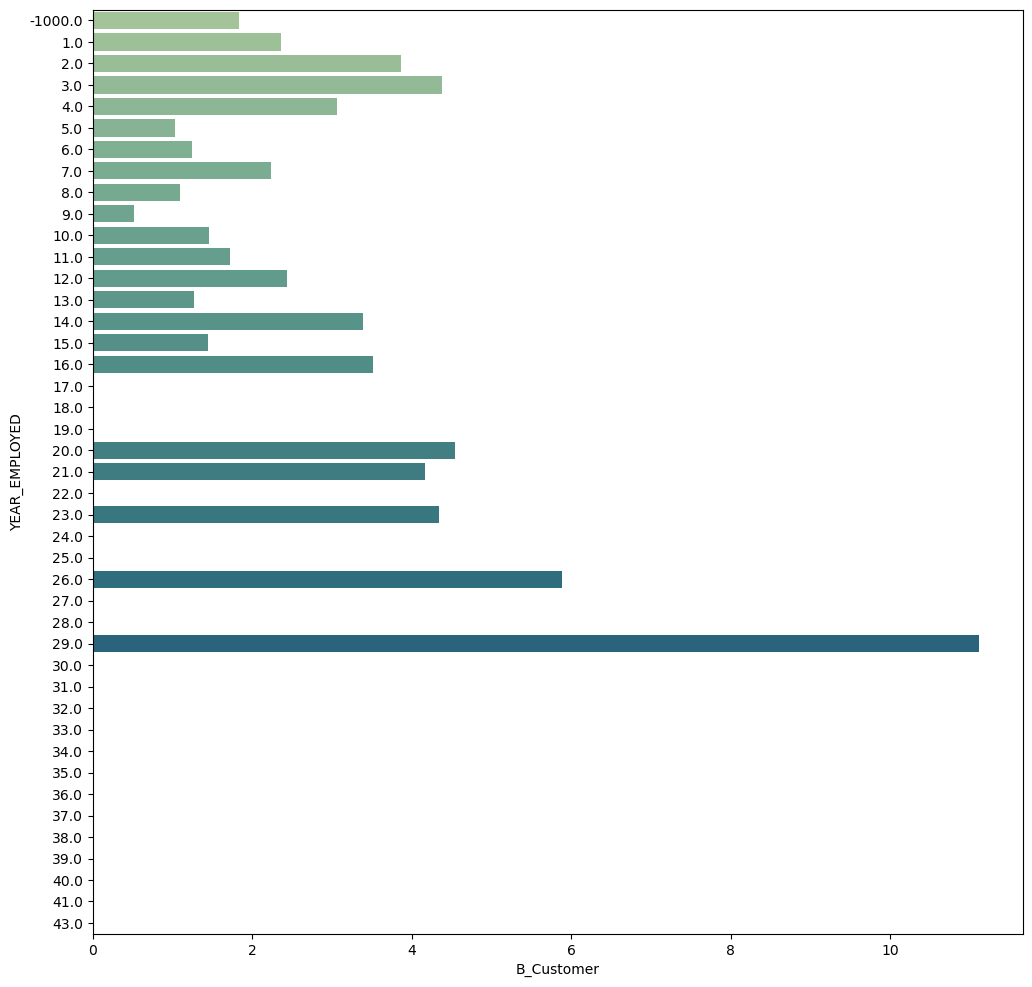

In [217]:
# Percentage of bad customer for each year employed`
fig, ax = plt.subplots(figsize=(12, 12))
df_year_percent_bad = df_labeled[["YEAR_EMPLOYED","B_Customer"]].groupby("YEAR_EMPLOYED",as_index=False).mean()
df_year_percent_bad["B_Customer"] = df_year_percent_bad["B_Customer"]*100
sns.barplot(data=df_year_percent_bad, y="YEAR_EMPLOYED", x="B_Customer",orient='h',palette="crest")

In [218]:
def gen_bin_year(df):
    # return group assigned for bin size = binSize
    # assign data > binOver to the last group
    binSize = 2
    binOver = 16
    if df == -1000:
        return str(1)
    elif df <= binOver:
        return str(math.ceil(df/binSize) + 1)
    else:
        return str(math.ceil(binOver/binSize) + 1)

In [219]:
df_labeled["YEAR_EMPLOYED_GROUP"] = df_labeled["YEAR_EMPLOYED"].apply(gen_bin_year)

Text(0.5, 1.0, 'Percentage of Bad Customer in each group')

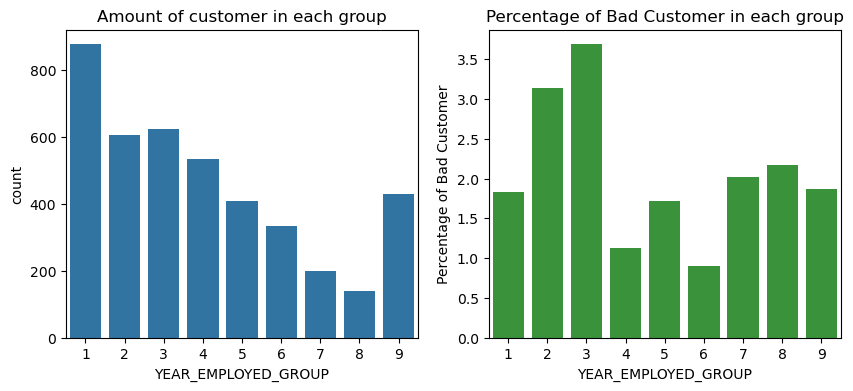

In [220]:
fig, ax = plt.subplots(1, 2, figsize = (10,4))
RowPlot = "YEAR_EMPLOYED_GROUP"
sns.countplot(data=df_labeled, x=RowPlot,ax=ax[0],order=map(str,range(1,10)), color='tab:blue')
ax[0].set_title("Amount of customer in each group")

df_fam_percent_bad = df_labeled[[RowPlot,"B_Customer"]].groupby(RowPlot,as_index=False).mean()
df_fam_percent_bad["B_Customer"] = df_fam_percent_bad["B_Customer"]*100
sns.barplot(data=df_fam_percent_bad, x=RowPlot, y="B_Customer", ax=ax[1], color='tab:green')
plt.ylabel("Percentage of Bad Customer")
ax[1].set_title("Percentage of Bad Customer in each group")

In [221]:
[WOE, IV] = WOE_cal(df_labeled,"YEAR_EMPLOYED_GROUP")
print("Information value (IV):", IV)
WOE

Information value (IV): 0.18326788992276247


,Dist_bad,Dist_good,WOE
YEAR_EMPLOYED_GROUP,,,
1,0.179775,0.211889,0.164357
2,0.213483,0.144795,-0.388237
3,0.258427,0.148249,-0.555722
4,0.067416,0.130242,0.658514
5,0.078652,0.098668,0.226731
6,0.033708,0.081401,0.881657
7,0.044944,0.047854,0.062741
8,0.033708,0.033300,-0.012160
9,0.089888,0.103601,0.141990


In [222]:
df_labeled= df_labeled.drop("YEAR_EMPLOYED",axis=1)
df_labeled["YEAR_EMPLOYED_GROUP"] = df_labeled["YEAR_EMPLOYED_GROUP"].astype('object')

#### Modeling

In [223]:
df_labeled.head()

,NAME_INCOME_TYPE,NAME_FAMILY_STATUS,OCCUPATION_TYPE,B_Customer,FAM_GROUP,AGE_GROUP,AMT_INCOME_TOTAL_GROUP,YEAR_EMPLOYED_GROUP
0,Working,Civil marriage,G5,0,2,3,1,8
1,Pensioner,Married,G4,0,2,6,1,1
2,Working,Married,G5,0,2,3,1,2
3,Pensioner,Married,G4,0,2,8,1,1
4,Pensioner,Single / not married,G4,0,1,7,1,1


In [224]:
df_labeled["B_Customer"].value_counts(normalize=True)*100

0    97.851798
1     2.148202
Name: B_Customer, dtype: float64

#### Split data into train and test set.

#### Handle imbalance data by using SMOTE.

#### Encode data

In [225]:
df_LogReg_one = df_labeled
x_LogReg = df_LogReg_one.drop("B_Customer",axis=1)
y_LogReg = df_LogReg_one["B_Customer"]
x_LogReg_train, x_LogReg_test, y_LogReg_train, y_LogReg_test = train_test_split(x_LogReg, y_LogReg, test_size=0.25, stratify=y_LogReg, random_state=42)

In [226]:
x_LogReg_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3107 entries, 2861 to 1167
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   NAME_INCOME_TYPE        3107 non-null   object
 1   NAME_FAMILY_STATUS      3107 non-null   object
 2   OCCUPATION_TYPE         3107 non-null   object
 3   FAM_GROUP               3107 non-null   object
 4   AGE_GROUP               3107 non-null   object
 5   AMT_INCOME_TOTAL_GROUP  3107 non-null   object
 6   YEAR_EMPLOYED_GROUP     3107 non-null   object
dtypes: object(7)
memory usage: 194.2+ KB


In [227]:
x_train_balance,y_train_balance = SMOTEN(random_state=10).fit_resample(x_LogReg_train,y_LogReg_train)
x_LogReg_train_encoded = pd.get_dummies(x_train_balance)
x_LogReg_test_encoded = pd.get_dummies(x_LogReg_test)

In [228]:
x_LogReg_test_encoded

,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated/Widow,NAME_FAMILY_STATUS_Single / not married,OCCUPATION_TYPE_G1,OCCUPATION_TYPE_G2,...,AMT_INCOME_TOTAL_GROUP_6,YEAR_EMPLOYED_GROUP_1,YEAR_EMPLOYED_GROUP_2,YEAR_EMPLOYED_GROUP_3,YEAR_EMPLOYED_GROUP_4,YEAR_EMPLOYED_GROUP_5,YEAR_EMPLOYED_GROUP_6,YEAR_EMPLOYED_GROUP_7,YEAR_EMPLOYED_GROUP_8,YEAR_EMPLOYED_GROUP_9
1771,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
566,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
664,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4063,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1873,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
534,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1140,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3590,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


#### Binary Logistic regression

In [229]:
y_train_balance

0       0
1       0
2       0
3       0
4       0
       ..
6075    1
6076    1
6077    1
6078    1
6079    1
Name: B_Customer, Length: 6080, dtype: int32

In [230]:
x_LogReg_train_encoded

,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated/Widow,NAME_FAMILY_STATUS_Single / not married,OCCUPATION_TYPE_G1,OCCUPATION_TYPE_G2,...,AMT_INCOME_TOTAL_GROUP_6,YEAR_EMPLOYED_GROUP_1,YEAR_EMPLOYED_GROUP_2,YEAR_EMPLOYED_GROUP_3,YEAR_EMPLOYED_GROUP_4,YEAR_EMPLOYED_GROUP_5,YEAR_EMPLOYED_GROUP_6,YEAR_EMPLOYED_GROUP_7,YEAR_EMPLOYED_GROUP_8,YEAR_EMPLOYED_GROUP_9
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6075,0,0,0,1,0,1,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
6076,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
6077,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
6078,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


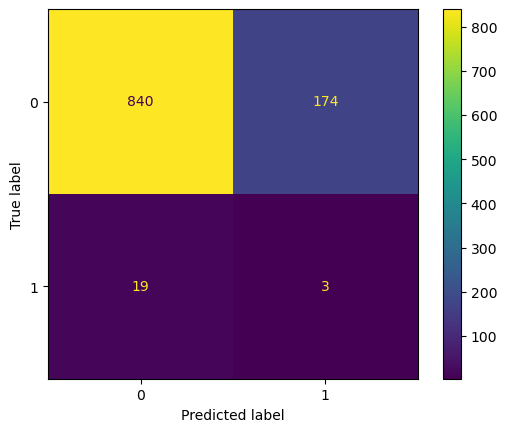

              precision    recall  f1-score   support

           0       0.98      0.83      0.90      1014
           1       0.02      0.14      0.03        22

    accuracy                           0.81      1036
   macro avg       0.50      0.48      0.46      1036
weighted avg       0.96      0.81      0.88      1036



In [246]:
log_clf = LogisticRegression(random_state=42, max_iter=2000).fit(x_LogReg_train_encoded, y_train_balance)
y_predict= log_clf.predict(x_LogReg_test_encoded)
log_cm = confusion_matrix(y_LogReg_test, y_predict, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()
print(classification_report(y_LogReg_test,y_predict))
y_pred_log = y_predict.copy()

In [247]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train_balance, log_clf.predict(x_LogReg_train_encoded))

# Calculate accuracy for test data
test_accuracy = accuracy_score(y_LogReg_test, y_predict)

print(f"Training data accuracy: {train_accuracy}")
print(f"Test data accuracy: {test_accuracy}")

Training data accuracy: 0.8893092105263158
Test data accuracy: 0.8137065637065637


#### Random Forest

In [238]:
cv_params = {'n_estimators' : [50,100,200], 
              'max_depth' : [10,20,50],
              'min_samples_leaf':[1,5,10]}
rf = RandomForestClassifier(random_state=0)
rf_val = GridSearchCV(rf, cv_params, refit='f1')
rf_val.fit(x_LogReg_train_encoded, y_train_balance)

GridSearchCV(estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [10, 20, 50],
                         'min_samples_leaf': [1, 5, 10],
                         'n_estimators': [50, 100, 200]},
             refit='f1')

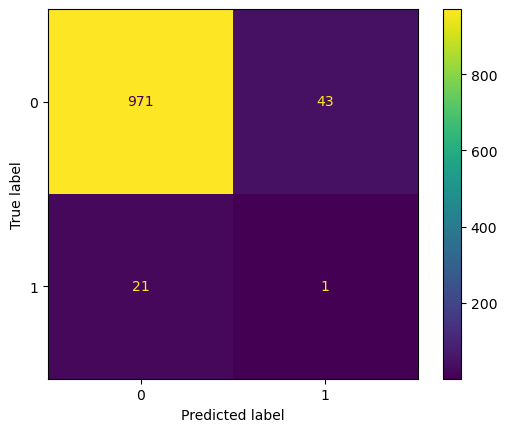

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1014
           1       0.02      0.05      0.03        22

    accuracy                           0.94      1036
   macro avg       0.50      0.50      0.50      1036
weighted avg       0.96      0.94      0.95      1036



In [239]:
import imblearn.over_sampling as os

x_train_resampled, y_train_resampled = os.SMOTE().fit_resample(x_LogReg_train_encoded, y_train_balance)
rf_val.fit(x_train_resampled, y_train_resampled)

y_predict = rf_val.predict(x_LogReg_test_encoded)
log_cm = confusion_matrix(y_LogReg_test, y_predict, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, 
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()
print(classification_report(y_LogReg_test,y_predict))
y_pred_rf = y_predict.copy()

In [245]:
from sklearn.metrics import accuracy_score

# Calculate accuracy for training data
train_accuracy = accuracy_score(y_train_balance, log_clf.predict(x_LogReg_train_encoded))

# Calculate accuracy for test data
test_accuracy = accuracy_score(y_LogReg_test, y_predict)

print(f"Training data accuracy: {train_accuracy}")
print(f"Test data accuracy: {test_accuracy}")

Training data accuracy: 0.8893092105263158
Test data accuracy: 0.9382239382239382


In [240]:
x_LogReg_train_encoded.to_csv('F://HND//ML//Assignment//x_LogReg_train_encoded.csv')

In [241]:
x_LogReg_train_encoded.head()

,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated/Widow,NAME_FAMILY_STATUS_Single / not married,OCCUPATION_TYPE_G1,OCCUPATION_TYPE_G2,...,AMT_INCOME_TOTAL_GROUP_6,YEAR_EMPLOYED_GROUP_1,YEAR_EMPLOYED_GROUP_2,YEAR_EMPLOYED_GROUP_3,YEAR_EMPLOYED_GROUP_4,YEAR_EMPLOYED_GROUP_5,YEAR_EMPLOYED_GROUP_6,YEAR_EMPLOYED_GROUP_7,YEAR_EMPLOYED_GROUP_8,YEAR_EMPLOYED_GROUP_9
0,0,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


### Making predictions

In [242]:
# Assuming input array is named input_array
input_array = np.array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])

# Reshape the input array to be a 2D array with a single sample
input_array_reshaped = input_array.reshape(1, -1)

# Make predictions
new_predictions = log_clf.predict(input_array_reshaped)

C:\Users\USER\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


In [243]:
print("Predicted class:", new_predictions[0])

Predicted class: 1
